In [5]:
from collections import Counter
from generator_class_multi_1226 import DataGenerator2
import glob
import random
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
plt.style.use('/home/sophiaf/mystyle.mplstyle')


In [4]:
def get_data(pixel_map_dir, generator):
    '''
    Get pixels maps 
    '''
    file_list_all = glob.glob(pixel_map_dir)
    file_list = []

    for f in file_list_all:
        if generator.get_info(f)['NuPDG'] != 16 and generator.get_info(f)['NuPDG'] != -16 and generator.get_info(f)['NuEnergy'] < 4.0:
            file_list.append(f)

    random.shuffle(file_list)
    split = int(.9*len(file_list)) # 10% for testing
    allfiles, testfiles = file_list[:split], file_list[split:]
    
    return allfiles, testfiles

In [5]:
def get_just_labels(generator, files):
    num_class_tasks = 6
    data_labels = np.zeros((len(files),num_class_tasks), dtype=np.int32)
    # data_labels = np.array()
    for i, file in enumerate(files):
        truth_info = generator.get_info(file)
        pdg = np.abs(truth_info['NuPDG'])
        if pdg == 1:
            interaction_label = 0 #NC
        elif pdg == 12:
            interaction_label = 1 #CC nu_e
        elif pdg == 14:
            interaction_label = 2 #CC nu_mu
        elif pdg == 16:
            interaction_label = 3 #CC nu_tau (not included in our E range but still here) 

        proton_label = np.clip(truth_info['NProton'], None, 3) # 0,1,2,or N Protons 
        pion_label = np.clip(truth_info['NPion'], None, 3) # 0,1,2,or N Pions 
        pizero_label = np.clip(truth_info['NPizero'], None, 3) # 0,1,2,or N Pizeros
        neutron_label = np.clip(truth_info['NNeutron'], None, 3) # 0,1,2,or N Neutrons 
        anti_label = truth_info['is_antineutrino']

        truth_labels = [interaction_label, 
                        proton_label, 
                        pion_label, pizero_label, neutron_label, anti_label
                       ]
        data_labels[i] = truth_labels
        #image loading part 
        # image = file[:-5] + '.gz'
        # data_maps.append(self.get_pixels_map(image))
    data_label_dict = {"flavour":np.array(data_labels[:,0]), 
                       "protons": data_labels[:,1], 
                       "pions": data_labels[:,2], "pizeros": data_labels[:,3], "neutrons": data_labels[:,4], "is_antineutrino": data_labels[:,5]
                      }
    return data_label_dict

In [4]:
pixel_maps_dir = '/home/sophiaf/pixel_maps_val/pixel_data_subset/*.info'
_files = glob.glob(pixel_maps_dir)

In [6]:
params = {'batch_size':64,'dim':(200,200), 'n_channels':3}
df = pd.read_pickle('/home/sophiaf/pixel_maps_val/preprocessed_filelists/scratch_urllist_0_1_2_10_11_12_df.pkl')
generator = DataGenerator2(_files, **params)

In [8]:
# labels = get_just_labels(generator, _files)
# pixelmaps, labels = generator.get_data_and_labels(data)

In [7]:
labels_flavour = ['NC', '$\\nu_e$', '$\\nu_\\mu$']
labels_n_particles = ['0', '1', '2', '3+']
labels_is_anti = ['$\\nu$', '$\\bar{\\nu}$']

conmat_axis_labels = {'flavour': labels_flavour, 'protons': labels_n_particles, 
                 'pions': labels_n_particles,
                 'pizeros': labels_n_particles,
                 'neutrons': labels_n_particles,
                 'is_antineutrino': labels_is_anti}

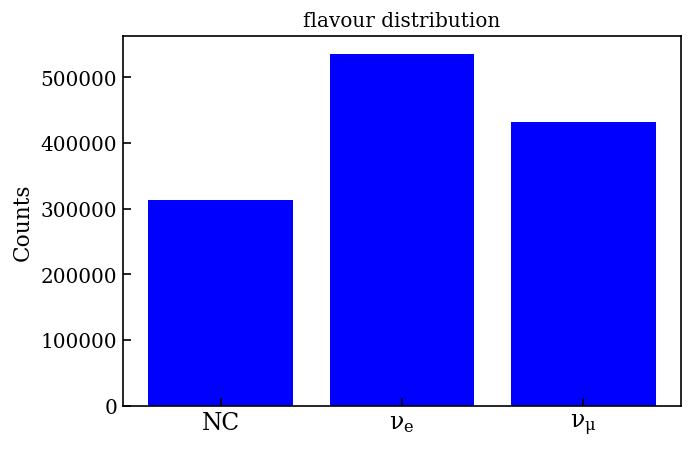

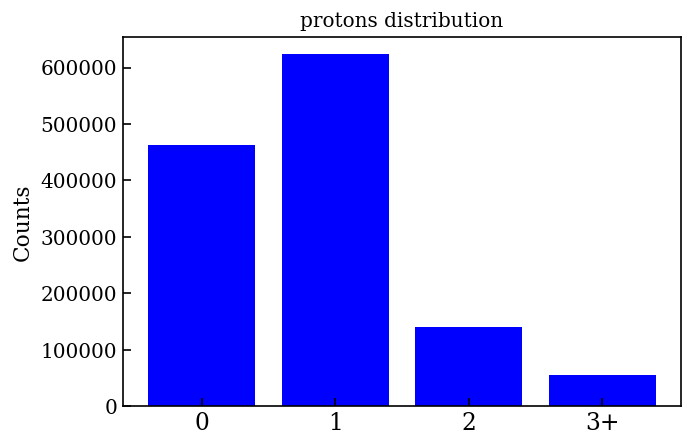

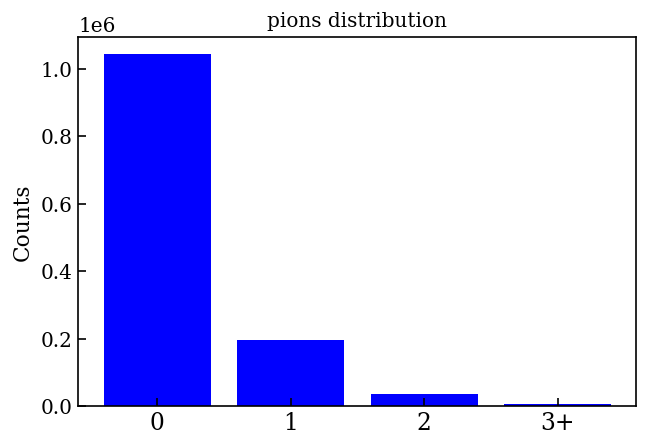

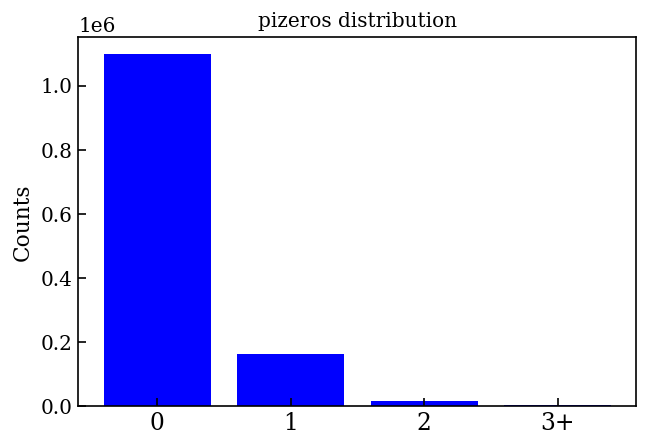

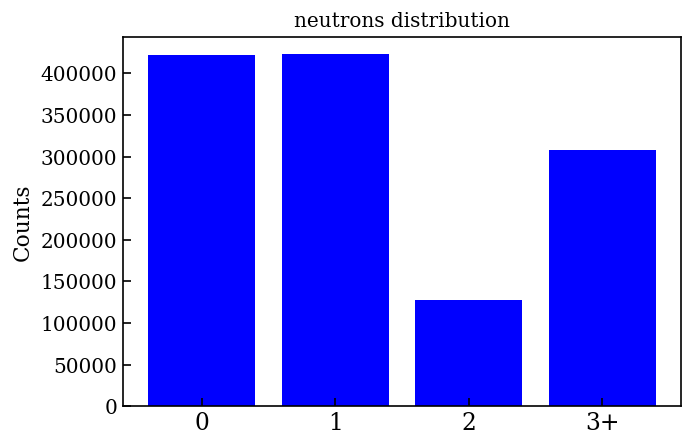

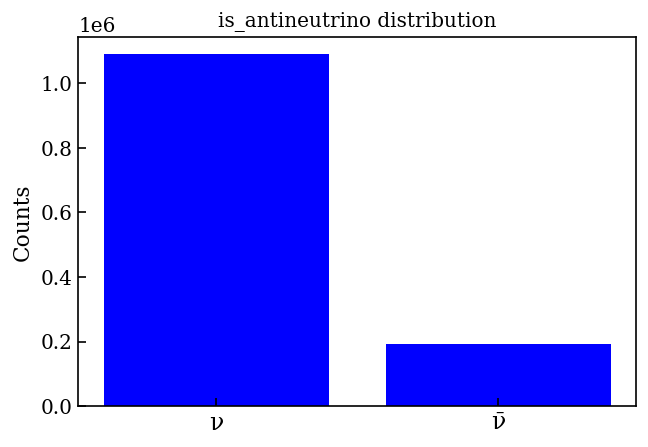

In [17]:
counts_per_class = {}

for i, key in enumerate(conmat_axis_labels.keys()):
    plt.hist(df[key],bins=np.arange(len(conmat_axis_labels[key])+1),
             histtype='barstacked', rwidth=0.8,
             align='left')
    
    counter = Counter(df[key])
    counts_per_class[key] = counter
    plt.xticks(ticks=np.arange(len(conmat_axis_labels[key])),labels=conmat_axis_labels[key], fontsize=14)
    plt.ylabel('Counts')
    # plt.yscale('log')
    plt.title('%s distribution'%(key))
    plt.savefig('model_eval_plots/%s_prior_distribution.pdf'%(key))
    plt.show()    

In [15]:
max(counts_per_class[key].values())

224147

In [21]:
sorted(class_weights)

['flavour', 'is_antineutrino', 'neutrons', 'pions', 'pizeros', 'protons']

In [14]:
class_weights = {}
for i, key in enumerate(conmat_axis_labels.keys()):
    max_val = max(counts_per_class[key].values())
    class_weights[key] = {class_id : max_val/num_images for class_id, num_images in sorted(counts_per_class[key].items())}  

In [15]:
class_weights['flavour'].pop(3)

KeyError: 3

In [16]:
class_weights

{'flavour': {0: 1.7124562850438907, 1: 1.0, 2: 1.2389368660119986},
 'protons': {0: 1.347878518063879,
  1: 1.0,
  2: 4.463913024807112,
  3: 11.387004308770905},
 'pions': {0: 1.0,
  1: 5.346341788231437,
  2: 29.49689142598768,
  3: 160.5069967707212},
 'pizeros': {0: 1.0,
  1: 6.720149116685643,
  2: 70.49942203955818,
  3: 264.72558476006753},
 'neutrons': {0: 1.002019556313185,
  1: 1.0,
  2: 3.319187815666468,
  3: 1.3750069039009476},
 'is_antineutrino': {0: 1.0, 1: 5.681365798698047}}

In [ ]:


train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(...)

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

model.fit_generator(...,
                    class_weight=class_weights)


In [ ]:
def make_hdf5_of_info():
    